### V. Modeling

* ### Data Pre-processing

In [38]:
%store -r df
%matplotlib inline
!pip install -U fsds

Requirement already up-to-date: fsds in /home/user/anaconda3/envs/flatiron/lib/python3.6/site-packages (0.2.27)


In [39]:
import fsds as fs
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from fsds.imports import *

## Project Notebook Settings
pd.set_option('display.max_columns',0)

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-notebook')

In [40]:
zipcode_list = df['Zipcode'].unique().tolist()

In [41]:
TS = {}
for zipcode in zipcode_list:
    temp_df = df.groupby('Zipcode').get_group(zipcode).sort_index()['value']
    TS[zipcode] = temp_df #df.loc[district]

In [42]:
TS.keys()

dict_keys(['6606', '6513', '6604', '6610', '6351', '6706', '6359', '6069', '6330', '6039', '6235', '6058', '6068'])

In [43]:
TS['6706']

Date
2008-01-01    152200.0
2008-02-01    151200.0
2008-03-01    150300.0
2008-04-01    149600.0
2008-05-01    149200.0
                ...   
2017-12-01    108900.0
2018-01-01    109800.0
2018-02-01    109500.0
2018-03-01    109000.0
2018-04-01    108600.0
Name: value, Length: 124, dtype: float64

In [44]:
ts_df = pd.DataFrame(TS)
ts_df.head()

,6606,6513,6604,6610,6351,6706,6359,6069,6330,6039,6235,6058,6068
Date,,,,,,,,,,,,,
2008-01-01,252300.0,187600.0,274700.0,216600.0,217300.0,152200.0,282100.0,436300.0,232100.0,535900.0,228700.0,350900.0,511000.0
2008-02-01,249500.0,185900.0,271300.0,213100.0,214400.0,151200.0,282000.0,437000.0,230400.0,537700.0,226500.0,345200.0,512400.0
2008-03-01,247000.0,184500.0,268600.0,210100.0,212800.0,150300.0,282100.0,436300.0,228900.0,538100.0,224400.0,340000.0,513100.0
2008-04-01,244700.0,183700.0,266600.0,207500.0,212100.0,149600.0,281600.0,434900.0,227800.0,538300.0,222700.0,336800.0,515400.0
2008-05-01,242400.0,183200.0,264600.0,205100.0,211900.0,149200.0,280500.0,433700.0,226700.0,536700.0,220600.0,336500.0,518200.0


* ### Modeling Individual Zipcode

In [45]:
zipcode = '6706'

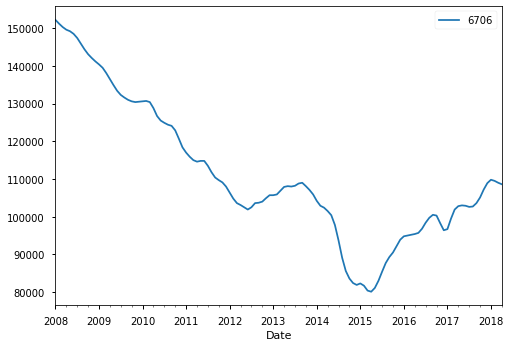

In [46]:
ts = ts_df[zipcode].copy()
ax = ts.plot()
ax.legend()
plt.show()

In [47]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.plotting import autocorrelation_plot,lag_plot

def plot_acf_pacf(ts, figsize=(10,8),lags=24):
    
    fig,ax = plt.subplots(nrows=3,
                          figsize=figsize)
    
    ## Plot ts
    ts.plot(ax=ax[0])
    
    ## Plot acf, pavf
    plot_acf(ts,ax=ax[1],lags=lags)
    plot_pacf(ts, ax=ax[2],lags=lags) 
    fig.tight_layout()
    
    fig.suptitle(f"Zipcode: {ts.name}",y=1.1,fontsize=20)
    
    for a in ax[1:]:
        a.xaxis.set_major_locator(mpl.ticker.MaxNLocator(min_n_ticks=lags, integer=True))
        a.xaxis.grid()
    return fig,ax

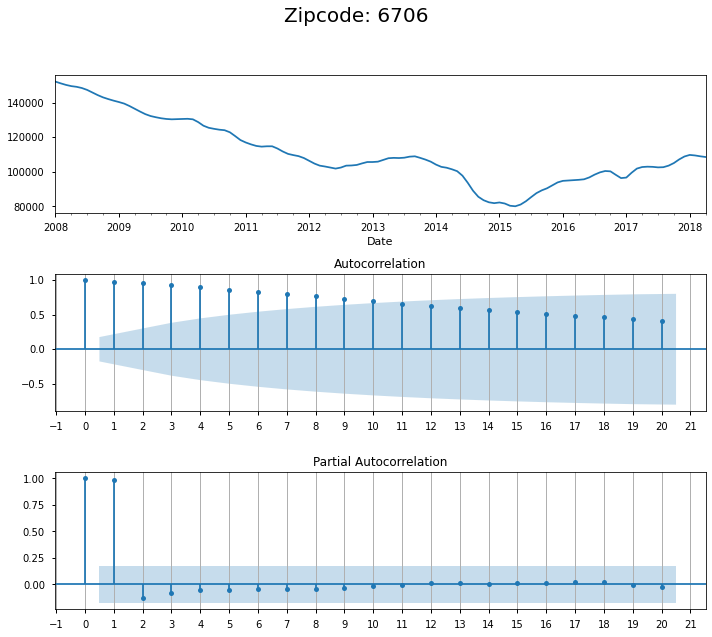

In [48]:
plot_acf_pacf(ts,lags=20);

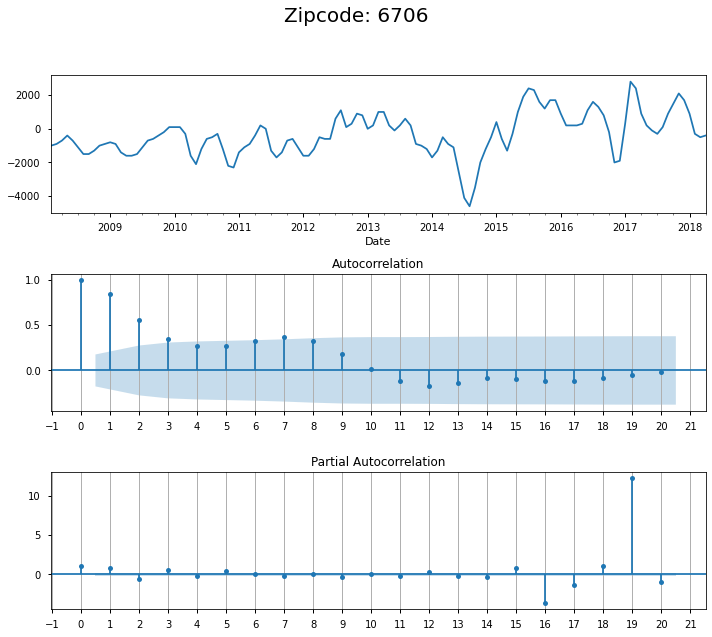

In [49]:
d = 1
plot_acf_pacf(ts.diff(d).dropna(),lags=20);

### First Model: Manually Selecting Params

In [50]:
# selected params
d = 1
p = 1
q =1

### Train Test Split

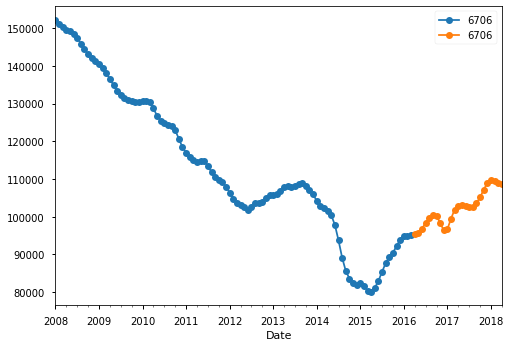

In [51]:
train_size = 0.8
split_idx = round(len(ts)* train_size)
split_idx

## Split
train = ts.iloc[:split_idx]
test = ts.iloc[split_idx:]

## Visualize split
fig,ax= plt.subplots()
kws = dict(ax=ax,marker='o')
train.plot(**kws)
test.plot(**kws)
ax.legend(bbox_to_anchor=[1,1])
plt.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   6706   No. Observations:                   99
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -833.096
Date:                Wed, 16 Dec 2020   AIC                           1672.192
Time:                        19:53:48   BIC                           1679.947
Sample:                    01-01-2008   HQIC                          1675.329
                         - 03-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9769      0.010     97.349      0.000       0.957       0.997
ma.L1         -0.9999      0.101     -9.903      0.000      -1.198      -0.802
sigma2      1.558e+06   6.13e-08   2.54e+13      0.000    1.56e+06    1.56e+06
===================================================================================
Ljung-Box (L1) (Q):                  74.21   Jarque-Bera (JB):                38.95
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               9.74   Skew:                            -0.95
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.99e+28. Standard errors may be unstable.
"""

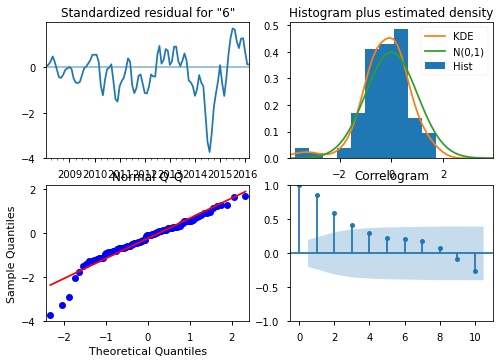

In [52]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Baseline model from eye-balled params
model = SARIMAX(train,order=(p,d,q),).fit()
display(model.summary())
model.plot_diagnostics();
plt.show()

In [53]:
len(test)

25

### Obtaining Forcast

In [54]:
## obtaining forecast
from sklearn import metrics
forecast = model.get_forecast(steps=len(test))

In [55]:
def forecast_to_df(forecast,zipcode):
    test_pred = forecast.conf_int()
    test_pred[zipcode] = forecast.predicted_mean
    test_pred.columns = ['lower','upper','prediction']
    return test_pred


pred_df = forecast_to_df(forecast,zipcode)

### Plotting Forecast

In [56]:
def plot_train_test_pred(train,test,pred_df):
    fig,ax = plt.subplots()
    kws = dict(marker='o')
    
    ax.plot(train,label='Train',**kws)
    ax.plot(test,label='Test',**kws)
    ax.plot(pred_df['prediction'],label='prediction',ls='--',**kws)

    ax.fill_between(x=pred_df.index,y1=pred_df['lower'],y2=pred_df['upper'])
    ax.legend(bbox_to_anchor=[1,1])
    fig.tight_layout()
    return fig,ax

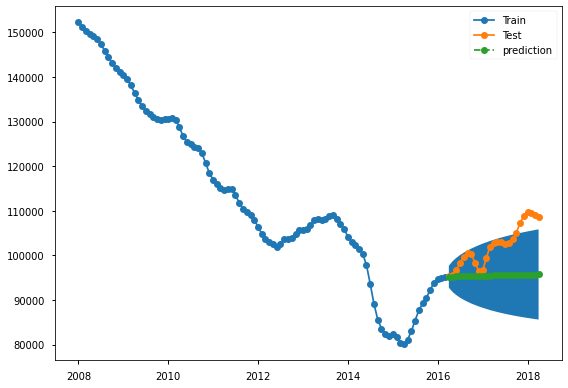

In [57]:
plot_train_test_pred(train,test,pred_df)
plt.show()

### Second Model: Selecting params with pmdarima

In [58]:
!pip install pmdarima
from pmdarima.arima import auto_arima

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   99
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -833.565
Date:                Wed, 16 Dec 2020   AIC                           1671.131
Time:                        19:54:12   BIC                           1676.301
Sample:                             0   HQIC                          1673.222
                                 - 99                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -581.6327    121.477     -4.788      0.000    -819.723    -343.542
sigma2      1.431e+06    1.6e+05      8.956      0.000    1.12e+06    1.74e+06
===================================================================================
Ljung-Box (L1) (Q):                  75.43   Jarque-Bera (JB):                 7.58
Prob(Q):                              0.00   Prob(JB):                         0.02
Heteroskedasticity (H):               7.58   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

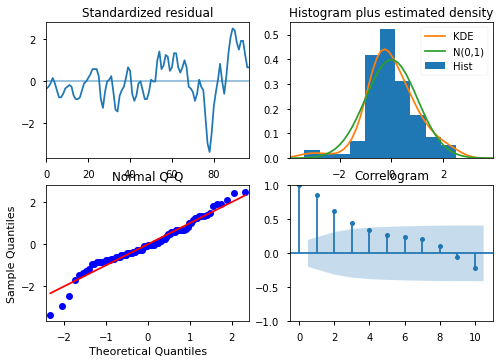

In [59]:
auto_model = auto_arima(train,start_p=0,start_q=0)
display(auto_model.summary())
auto_model.plot_diagnostics();

In [60]:
pd.date_range(train.index[-1], periods=10,freq='M')

DatetimeIndex(['2016-03-31', '2016-04-30', '2016-05-31', '2016-06-30',
               '2016-07-31', '2016-08-31', '2016-09-30', '2016-10-31',
               '2016-11-30', '2016-12-31'],
              dtype='datetime64[ns]', freq='M')

In [61]:
train.index

DatetimeIndex(['2008-01-01', '2008-02-01', '2008-03-01', '2008-04-01',
               '2008-05-01', '2008-06-01', '2008-07-01', '2008-08-01',
               '2008-09-01', '2008-10-01', '2008-11-01', '2008-12-01',
               '2009-01-01', '2009-02-01', '2009-03-01', '2009-04-01',
               '2009-05-01', '2009-06-01', '2009-07-01', '2009-08-01',
               '2009-09-01', '2009-10-01', '2009-11-01', '2009-12-01',
               '2010-01-01', '2010-02-01', '2010-03-01', '2010-04-01',
               '2010-05-01', '2010-06-01', '2010-07-01', '2010-08-01',
               '2010-09-01', '2010-10-01', '2010-11-01', '2010-12-01',
               '2011-01-01', '2011-02-01', '2011-03-01', '2011-04-01',
               '2011-05-01', '2011-06-01', '2011-07-01', '2011-08-01',
               '2011-09-01', '2011-10-01', '2011-11-01', '2011-12-01',
               '2012-01-01', '2012-02-01', '2012-03-01', '2012-04-01',
               '2012-05-01', '2012-06-01', '2012-07-01', '2012-08-01',
      

In [62]:
pred_mean,pred_conf_int = auto_model.predict(return_conf_int=True)
pred_mean 

array([94618.36734694, 94036.73469388, 93455.10204082, 92873.46938776,
       92291.83673469, 91710.20408163, 91128.57142857, 90546.93877551,
       89965.30612245, 89383.67346939])

In [63]:
pred_df = pd.DataFrame({'pred':pred_mean, 
                        'conf_int_lower':pred_conf_int[:,0],
                        'conf_int_upper':pred_conf_int[:,1]},
                        index= pd.date_range(test.index[0],
                                                  periods=10,freq='M'))
# auto_model.conf_int()
pred_df

,pred,conf_int_lower,conf_int_upper
2016-04-30,94618.367347,92274.031616,96962.703077
2016-05-31,94036.734694,90721.343309,97352.126079
2016-06-30,93455.102041,89394.593446,97515.610636
2016-07-31,92873.469388,88184.797927,97562.140849
2016-08-31,92291.836735,87049.742679,97533.930790
2016-09-30,91710.204082,85967.777756,97452.630407
2016-10-31,91128.571429,84926.042096,97331.100761
2016-11-30,90546.938776,83916.156006,97177.721545
2016-12-31,89965.306122,82932.298931,96998.313314
2017-01-31,89383.673469,81970.232961,96797.113978


In [64]:
train.index[-1]

Timestamp('2016-03-01 00:00:00')

In [65]:
auto_model.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (0, 1, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

### Best_model

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   6706   No. Observations:                  124
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1058.117
Date:                Wed, 16 Dec 2020   AIC                           2118.234
Time:                        19:54:20   BIC                           2121.046
Sample:                    01-01-2008   HQIC                          2119.376
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.722e+06   1.85e+05      9.330      0.000    1.36e+06    2.08e+06
===================================================================================
Ljung-Box (L1) (Q):                  90.11   Jarque-Bera (JB):                 3.49
Prob(Q):                              0.00   Prob(JB):                         0.17
Heteroskedasticity (H):               1.38   Skew:                            -0.12
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

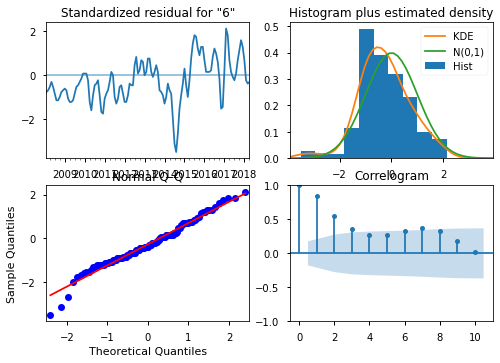

In [66]:
best_model = SARIMAX(ts,order=auto_model.order,
                     seasonal_order=auto_model.seasonal_order).fit()
display(best_model.summary())
best_model.plot_diagnostics();

(<Figure size 576x396 with 1 Axes>, <AxesSubplot:>)

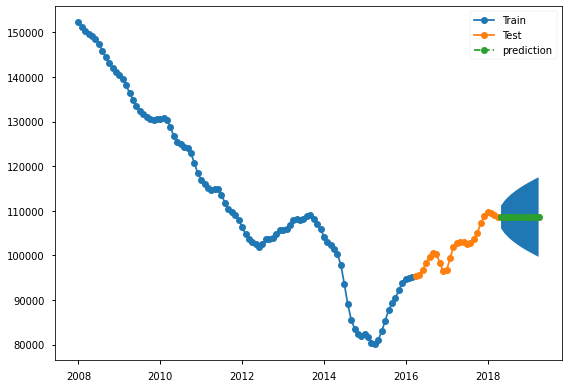

In [68]:
pred = best_model.get_forecast(steps=12)#start=test.index[0],end=test.index[-1])
pred_df = forecast_to_df(pred,zipcode)
display(plot_train_test_pred(train,test,pred_df));
plt.show()

### Implementingmy Best Model in a Loop

6606


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   6606   No. Observations:                   99
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -782.638
Date:                Wed, 16 Dec 2020   AIC                           1567.277
Time:                        19:54:38   BIC                           1569.852
Sample:                    01-01-2008   HQIC                          1568.318
                         - 03-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.963e+05   8.08e+04      7.378      0.000    4.38e+05    7.55e+05
===================================================================================
Ljung-Box (L1) (Q):                  19.26   Jarque-Bera (JB):                 0.71
Prob(Q):                              0.00   Prob(JB):                         0.70
Heteroskedasticity (H):               0.85   Skew:                            -0.16
Prob(H) (two-sided):                  0.65   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

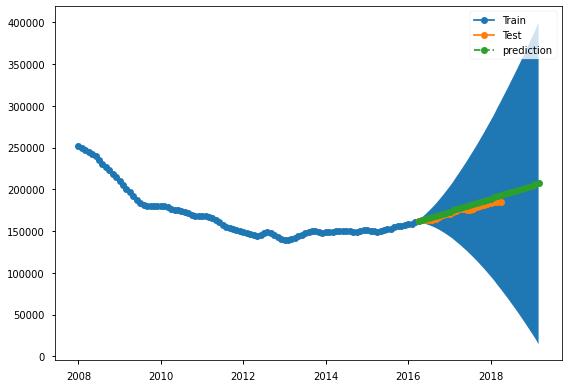

------------------------------------------------------------

6513


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   6513   No. Observations:                   99
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -770.104
Date:                Wed, 16 Dec 2020   AIC                           1542.207
Time:                        19:54:38   BIC                           1544.782
Sample:                    01-01-2008   HQIC                          1543.248
                         - 03-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.605e+05   7.44e+04      6.189      0.000    3.15e+05    6.06e+05
===================================================================================
Ljung-Box (L1) (Q):                  15.92   Jarque-Bera (JB):                 0.75
Prob(Q):                              0.00   Prob(JB):                         0.69
Heteroskedasticity (H):               1.05   Skew:                             0.01
Prob(H) (two-sided):                  0.89   Kurtosis:                         2.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

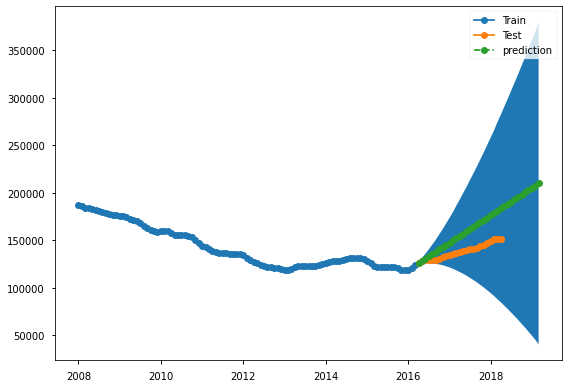

------------------------------------------------------------

6604


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   6604   No. Observations:                   99
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -826.255
Date:                Wed, 16 Dec 2020   AIC                           1654.511
Time:                        19:54:39   BIC                           1657.086
Sample:                    01-01-2008   HQIC                          1655.552
                         - 03-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.449e+06   1.55e+05      9.352      0.000    1.15e+06    1.75e+06
===================================================================================
Ljung-Box (L1) (Q):                  22.99   Jarque-Bera (JB):                15.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.37   Skew:                             0.68
Prob(H) (two-sided):                  0.38   Kurtosis:                         4.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

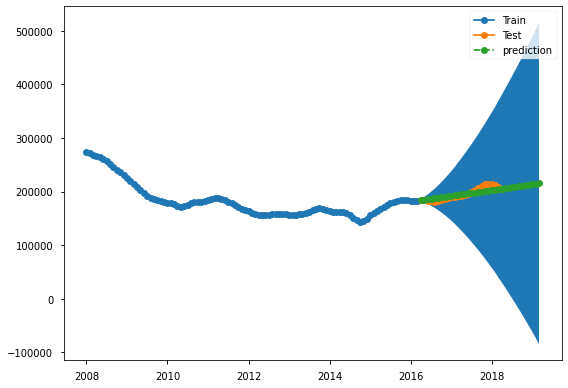

------------------------------------------------------------

6610


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   6610   No. Observations:                   99
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -814.180
Date:                Wed, 16 Dec 2020   AIC                           1630.360
Time:                        19:54:39   BIC                           1632.935
Sample:                    01-01-2008   HQIC                          1631.401
                         - 03-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.143e+06   1.44e+05      7.939      0.000    8.61e+05    1.43e+06
===================================================================================
Ljung-Box (L1) (Q):                   8.74   Jarque-Bera (JB):                 1.49
Prob(Q):                              0.00   Prob(JB):                         0.48
Heteroskedasticity (H):               0.67   Skew:                             0.07
Prob(H) (two-sided):                  0.27   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

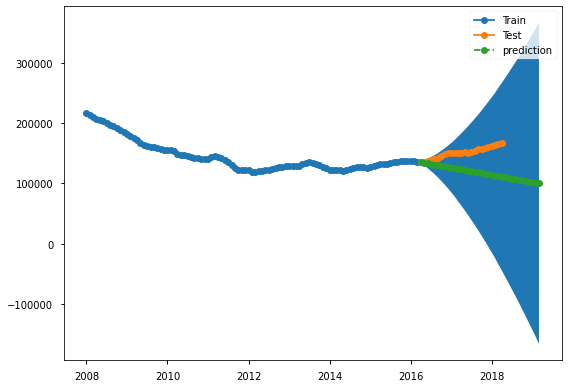

------------------------------------------------------------

6351


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   6351   No. Observations:                   99
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -872.874
Date:                Wed, 16 Dec 2020   AIC                           1751.748
Time:                        19:54:41   BIC                           1759.503
Sample:                    01-01-2008   HQIC                          1754.885
                         - 03-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9926      0.653     -1.519      0.129      -2.273       0.288
ma.L1          0.9925      0.655      1.515      0.130      -0.292       2.277
sigma2      3.191e+06   6.51e-08    4.9e+13      0.000    3.19e+06    3.19e+06
===================================================================================
Ljung-Box (L1) (Q):                  64.42   Jarque-Bera (JB):                 1.42
Prob(Q):                              0.00   Prob(JB):                         0.49
Heteroskedasticity (H):               0.73   Skew:                            -0.10
Prob(H) (two-sided):                  0.38   Kurtosis:                         2.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.26e+29. Standard errors may be unstable.
"""

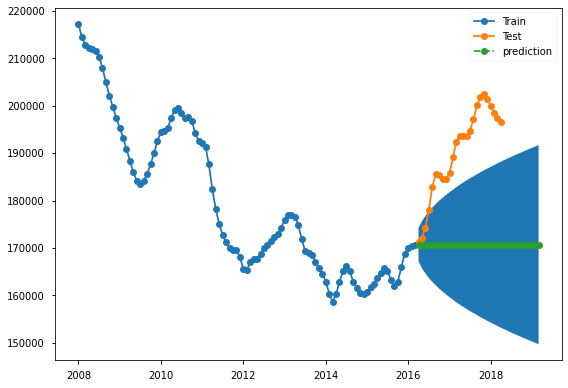

------------------------------------------------------------

6706


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   6706   No. Observations:                   99
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -843.968
Date:                Wed, 16 Dec 2020   AIC                           1689.937
Time:                        19:54:42   BIC                           1692.522
Sample:                    01-01-2008   HQIC                          1690.982
                         - 03-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.751e+06   2.01e+05      8.694      0.000    1.36e+06    2.15e+06
===================================================================================
Ljung-Box (L1) (Q):                  75.43   Jarque-Bera (JB):                 7.58
Prob(Q):                              0.00   Prob(JB):                         0.02
Heteroskedasticity (H):               2.84   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

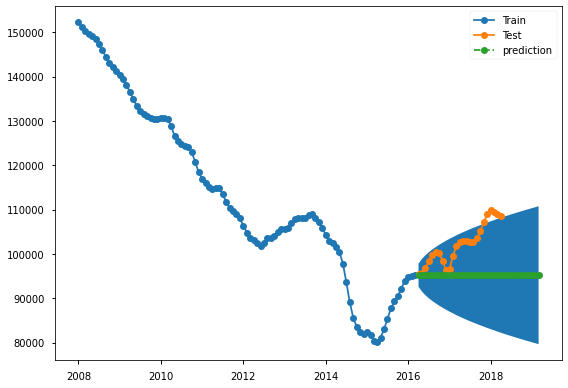

------------------------------------------------------------

6359


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   6359   No. Observations:                   99
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -822.602
Date:                Wed, 16 Dec 2020   AIC                           1647.205
Time:                        19:54:42   BIC                           1649.779
Sample:                    01-01-2008   HQIC                          1648.246
                         - 03-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       1.36e+06   1.91e+05      7.103      0.000    9.84e+05    1.73e+06
===================================================================================
Ljung-Box (L1) (Q):                  14.64   Jarque-Bera (JB):                 1.62
Prob(Q):                              0.00   Prob(JB):                         0.45
Heteroskedasticity (H):               3.51   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

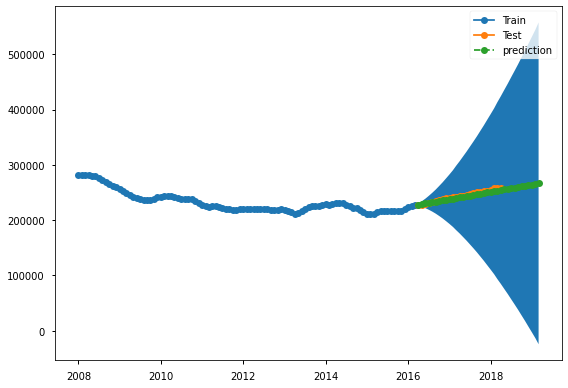

------------------------------------------------------------

6069


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   6069   No. Observations:                   99
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -893.907
Date:                Wed, 16 Dec 2020   AIC                           1789.815
Time:                        19:54:43   BIC                           1792.389
Sample:                    01-01-2008   HQIC                          1790.856
                         - 03-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.795e+06   7.07e+05      8.193      0.000    4.41e+06    7.18e+06
===================================================================================
Ljung-Box (L1) (Q):                   7.44   Jarque-Bera (JB):                 2.14
Prob(Q):                              0.01   Prob(JB):                         0.34
Heteroskedasticity (H):               1.59   Skew:                             0.16
Prob(H) (two-sided):                  0.20   Kurtosis:                         3.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

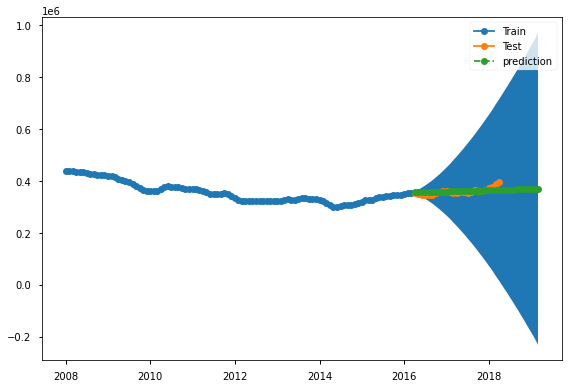

------------------------------------------------------------

6330


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   6330   No. Observations:                   99
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -862.285
Date:                Wed, 16 Dec 2020   AIC                           1726.571
Time:                        19:54:43   BIC                           1729.156
Sample:                    01-01-2008   HQIC                          1727.617
                         - 03-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.545e+06   3.41e+05      7.453      0.000    1.88e+06    3.21e+06
===================================================================================
Ljung-Box (L1) (Q):                  61.06   Jarque-Bera (JB):                 0.55
Prob(Q):                              0.00   Prob(JB):                         0.76
Heteroskedasticity (H):               0.65   Skew:                            -0.18
Prob(H) (two-sided):                  0.22   Kurtosis:                         3.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

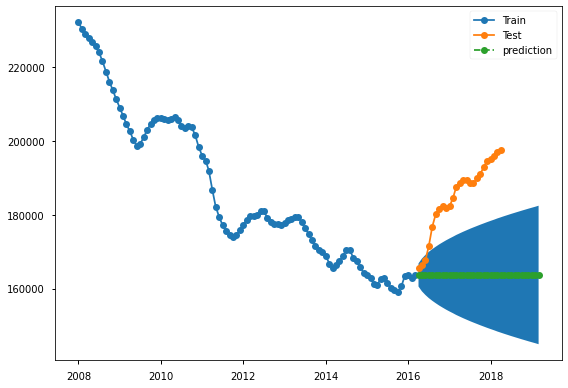

------------------------------------------------------------

6039


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   6039   No. Observations:                   99
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -931.433
Date:                Wed, 16 Dec 2020   AIC                           1864.865
Time:                        19:54:43   BIC                           1867.440
Sample:                    01-01-2008   HQIC                          1865.906
                         - 03-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.256e+07   1.73e+06      7.243      0.000    9.16e+06     1.6e+07
===================================================================================
Ljung-Box (L1) (Q):                  10.07   Jarque-Bera (JB):                 1.45
Prob(Q):                              0.00   Prob(JB):                         0.48
Heteroskedasticity (H):               1.50   Skew:                            -0.30
Prob(H) (two-sided):                  0.26   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

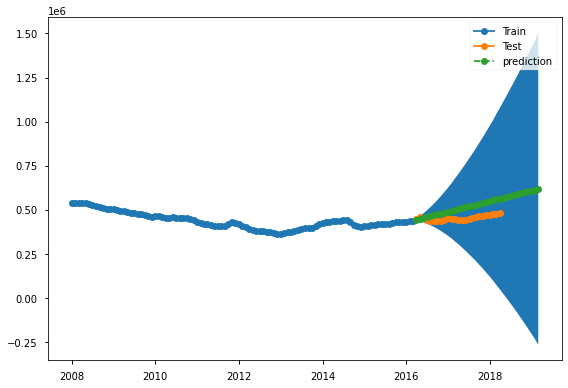

------------------------------------------------------------

6235


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   6235   No. Observations:                   99
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -816.469
Date:                Wed, 16 Dec 2020   AIC                           1634.939
Time:                        19:54:44   BIC                           1637.513
Sample:                    01-01-2008   HQIC                          1635.980
                         - 03-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.198e+06   1.26e+05      9.514      0.000    9.51e+05    1.44e+06
===================================================================================
Ljung-Box (L1) (Q):                   6.17   Jarque-Bera (JB):                12.11
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.86   Skew:                             0.06
Prob(H) (two-sided):                  0.08   Kurtosis:                         4.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

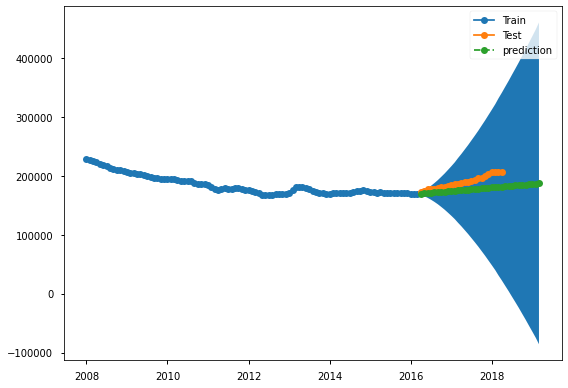

------------------------------------------------------------

6058


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   6058   No. Observations:                   99
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -934.183
Date:                Wed, 16 Dec 2020   AIC                           1870.365
Time:                        19:54:45   BIC                           1872.950
Sample:                    01-01-2008   HQIC                          1871.411
                         - 03-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.104e+07   1.54e+06      7.179      0.000    8.02e+06    1.41e+07
===================================================================================
Ljung-Box (L1) (Q):                  57.70   Jarque-Bera (JB):                 3.05
Prob(Q):                              0.00   Prob(JB):                         0.22
Heteroskedasticity (H):               0.85   Skew:                             0.36
Prob(H) (two-sided):                  0.65   Kurtosis:                         3.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

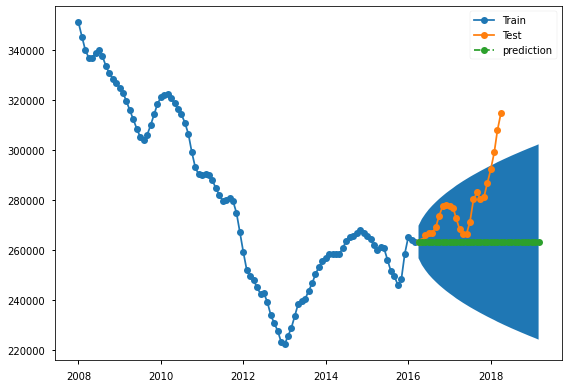

------------------------------------------------------------

6068


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   6068   No. Observations:                   99
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1004.790
Date:                Wed, 16 Dec 2020   AIC                           2011.579
Time:                        19:54:45   BIC                           2014.164
Sample:                    01-01-2008   HQIC                          2012.625
                         - 03-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.663e+07   5.65e+06      8.258      0.000    3.56e+07    5.77e+07
===================================================================================
Ljung-Box (L1) (Q):                  65.96   Jarque-Bera (JB):                 2.61
Prob(Q):                              0.00   Prob(JB):                         0.27
Heteroskedasticity (H):               2.58   Skew:                            -0.22
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

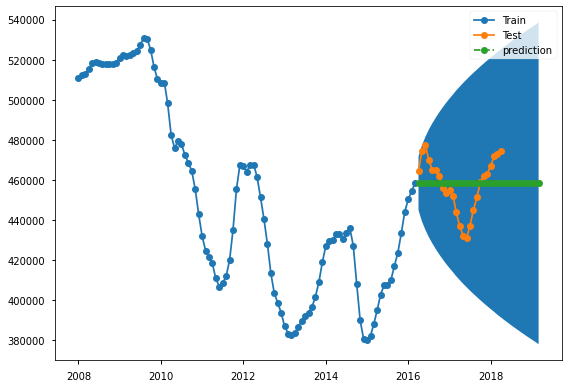

------------------------------------------------------------



In [69]:
RESULTS = {}

for zipcode in zipcode_list:
    print(zipcode)
    
    ## Make empty dict for district data
    zipcode_d = {}
    
    ## Copy Time Series
    ts = ts_df[zipcode].copy()
    
    
    ## Train Test Split Index
    train_size = 0.8
    split_idx = round(len(ts)* train_size)

    ## Split
    train = ts.iloc[:split_idx]
    test = ts.iloc[split_idx:]
    
    
    ## Get best params using auto_arima
    gridsearch_model = auto_arima(train,start_p=0,start_q=0)
    best_model = SARIMAX(train,order=gridsearch_model.order,
                     seasonal_order=gridsearch_model.seasonal_order).fit()
    
    ## Get predictions
    pred  = best_model.get_forecast(steps=36)#start=test.index[0],end=test.index[-1])
    pred_df = forecast_to_df(pred,zipcode)

    ## Save info to dict
    zipcode_d['pred_df'] = pred_df
    zipcode_d['model'] = best_model
    zipcode_d['train'] = train
    zipcode_d['test'] = test
    
    ## Display Results
    display(best_model.summary())
    plot_train_test_pred(train,test,pred_df)
    plt.show()
    
    
    ## Save district dict in RESULTS
    RESULTS[zipcode] = zipcode_d
    print('---'*20,end='\n\n')

### Recommendations
Out of the 13 zipcodes selected per historic ROI, I will recommend the 5 zipcodes that show an upward trend in both the test and prediction curves. 

In [70]:
%store -r melted_df

* ### 6513

In [71]:
melted_df.loc[melted_df['Zipcode']=='6513']

,Zipcode,Metro,SizeRank,ROI_5yr,ROI_3yr,value
Date,,,,,,
2008-01-01,6513,New Haven,2301,0.2725,0.1943,187600.0
2008-02-01,6513,New Haven,2301,0.2725,0.1943,185900.0
2008-03-01,6513,New Haven,2301,0.2725,0.1943,184500.0
2008-04-01,6513,New Haven,2301,0.2725,0.1943,183700.0
2008-05-01,6513,New Haven,2301,0.2725,0.1943,183200.0
...,...,...,...,...,...,...
2017-12-01,6513,New Haven,2301,0.2725,0.1943,146700.0
2018-01-01,6513,New Haven,2301,0.2725,0.1943,149100.0
2018-02-01,6513,New Haven,2301,0.2725,0.1943,150900.0


* ### 6606

In [72]:
melted_df.loc[melted_df['Zipcode']=='6606']

,Zipcode,Metro,SizeRank,ROI_5yr,ROI_3yr,value
Date,,,,,,
2008-01-01,6606,Stamford,1332,0.3202,0.235,252300.0
2008-02-01,6606,Stamford,1332,0.3202,0.235,249500.0
2008-03-01,6606,Stamford,1332,0.3202,0.235,247000.0
2008-04-01,6606,Stamford,1332,0.3202,0.235,244700.0
2008-05-01,6606,Stamford,1332,0.3202,0.235,242400.0
...,...,...,...,...,...,...
2017-12-01,6606,Stamford,1332,0.3202,0.235,182600.0
2018-01-01,6606,Stamford,1332,0.3202,0.235,183700.0
2018-02-01,6606,Stamford,1332,0.3202,0.235,184300.0


* ### 6359

In [73]:
melted_df.loc[melted_df['Zipcode']=='6359']

,Zipcode,Metro,SizeRank,ROI_5yr,ROI_3yr,value
Date,,,,,,
2008-01-01,6359,New London,10786,0.1761,0.2112,282100.0
2008-02-01,6359,New London,10786,0.1761,0.2112,282000.0
2008-03-01,6359,New London,10786,0.1761,0.2112,282100.0
2008-04-01,6359,New London,10786,0.1761,0.2112,281600.0
2008-05-01,6359,New London,10786,0.1761,0.2112,280500.0
...,...,...,...,...,...,...
2017-12-01,6359,New London,10786,0.1761,0.2112,252900.0
2018-01-01,6359,New London,10786,0.1761,0.2112,254700.0
2018-02-01,6359,New London,10786,0.1761,0.2112,257200.0


* ### 6604

In [74]:
melted_df.loc[melted_df['Zipcode']=='6604']

,Zipcode,Metro,SizeRank,ROI_5yr,ROI_3yr,value
Date,,,,,,
2008-01-01,6604,Stamford,3778,0.3141,0.316,274700.0
2008-02-01,6604,Stamford,3778,0.3141,0.316,271300.0
2008-03-01,6604,Stamford,3778,0.3141,0.316,268600.0
2008-04-01,6604,Stamford,3778,0.3141,0.316,266600.0
2008-05-01,6604,Stamford,3778,0.3141,0.316,264600.0
...,...,...,...,...,...,...
2017-12-01,6604,Stamford,3778,0.3141,0.316,214300.0
2018-01-01,6604,Stamford,3778,0.3141,0.316,214200.0
2018-02-01,6604,Stamford,3778,0.3141,0.316,213100.0


* ### 6039

In [75]:
melted_df.loc[melted_df['Zipcode']=='6039']

,Zipcode,Metro,SizeRank,ROI_5yr,ROI_3yr,value
Date,,,,,,
2008-01-01,6039,Torrington,13065,0.3212,0.2073,535900.0
2008-02-01,6039,Torrington,13065,0.3212,0.2073,537700.0
2008-03-01,6039,Torrington,13065,0.3212,0.2073,538100.0
2008-04-01,6039,Torrington,13065,0.3212,0.2073,538300.0
2008-05-01,6039,Torrington,13065,0.3212,0.2073,536700.0
...,...,...,...,...,...,...
2017-12-01,6039,Torrington,13065,0.3212,0.2073,468200.0
2018-01-01,6039,Torrington,13065,0.3212,0.2073,471500.0
2018-02-01,6039,Torrington,13065,0.3212,0.2073,473700.0
